In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.vq import kmeans, kmeans2, whiten, vq
import sklearn
from sklearn import metrics
from scipy.spatial.distance import cdist
%matplotlib inline

In [0]:
evo_travels = pd.read_csv('travels_id.csv')

## Useful Functions

In [0]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate distance between the geo coordinates
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000

    return m

In [0]:
def plot_elbow(data, k, mark=4, title='Elbow for K-Means clustering'):
    """
    Calculates the kmeans for k number of clusters and plot a figure
    to be used the elbow method.
    """

    # Normalizing
    X = whiten(data)

    K = range(1,k)

    print('Calculating Kmeans...')
    KM = [kmeans(X,k) for k in K] # apply kmeans 1 to k
    centroids = [cent for (cent,var) in KM]   # cluster centroids

    print('Calculating distance...')
    D_k = [cdist(X, cent, 'euclidean') for cent in centroids]

    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]  

    print('All Done!')
    kIdx = mark - 1

    # plot elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    tt = plt.title(title)  

    plt.show()

In [0]:
def hour_stats(data, hour):
  
    hour_data = data[data['hour'] == hour]['percentage']

    stats = {}

    stats['mean'] = hour_data.mean()
    stats['median'] = hour_data.median()
    stats['q1'] = hour_data.quantile(.25)
    stats['q3'] = hour_data.quantile(.75)
    stats['q4'] = hour_data.quantile(1)
    stats['std'] = hour_data.std()

    return stats

In [0]:
# Colors for the clusters
LABEL_COLOR_MAP = {0: '#920000',
                   1: '#004949',
                   2: '#ff6db6',
                   3: '#490092',
                   4: '#dbd100',
                   5: '#000000',
                   6: '#b66dff',
                   7: '#ffff6d'}

Raw data and divisions of North Vancouver and New Westminster

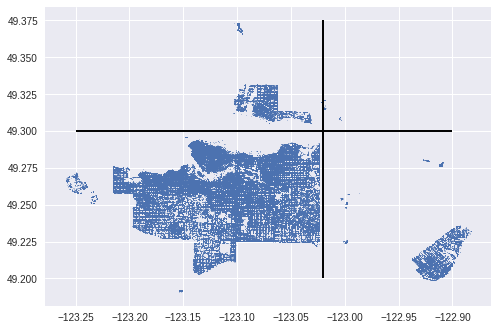

In [0]:
plt.hlines(49.3,-123.25,-122.9)
plt.vlines(-123.02,49.2,49.375)

plt.scatter(coordinates['Start_lon'], coordinates['Start_lat'], s=0.1)
plt.show()

## Data manipulation

In [0]:
evo_travels['Start_time'] = pd.to_datetime(evo_travels['Start_time'])
evo_travels['End_time'] = pd.to_datetime(evo_travels['End_time'])

# Adding a distance(m) column
evo_travels['distance'] = evo_travels.apply(lambda x: haversine(x.Start_lon,x.Start_lat,
                                                                x.End_lon,x.End_lat), axis=1)

# Columns of hour and weekday of each occurrence
evo_travels['hour'] = evo_travels['Start_time'].dt.hour
evo_travels['weekday'] = evo_travels['Start_time'].dt.weekday # 0 = Monday, 6 = Sunday

# Binary columns of daily periods
evo_travels['dawn'] = (evo_travels['hour'] < 6).astype('int')
evo_travels['morning'] = ((evo_travels['hour'] >= 6) & (evo_travels['hour'] < 12)).astype('int')
evo_travels['afternoon'] = ((evo_travels['hour'] >= 12) & (evo_travels['hour'] < 18)).astype('int')
evo_travels['night'] = ((evo_travels['hour'] >= 18) & (evo_travels['hour'] <= 23)).astype('int')

# Removing New Westminster
evo_travels = evo_travels[(evo_travels['Start_lon'] < -123.02)]
evo_travels = evo_travels[(evo_travels['End_lon'] < -123.02)]

In [0]:
evo_travels.head()

,Id,Start_time,Start_lat,Start_lon,Fuel_start,End_time,End_lat,End_lon,Fuel_end,duration,distance,hour,weekday,dawn,morning,afternoon,night
1,JTDKDTB32G1589000,2018-03-02 02:09:30.383898,49.314045,-123.083481,84,2018-03-02 02:33:40.410390,49.314045,-123.083481,84,24.167108,0.000000e+00,2,4,1,0,0,0
2,JTDKDTB32G1589000,2018-03-02 02:36:09.073847,49.314045,-123.083481,84,2018-03-02 04:24:36.451198,49.315067,-123.083481,83,108.456289,1.136032e+02,2,4,1,0,0,0
3,JTDKDTB32G1589000,2018-03-02 04:39:21.714875,49.315067,-123.083481,83,2018-03-02 05:09:48.876096,49.315067,-123.083481,83,30.452687,7.068790e-10,4,4,1,0,0,0
4,JTDKDTB32G1589000,2018-03-02 05:12:05.647857,49.315067,-123.083481,83,2018-03-02 05:15:26.307443,49.315067,-123.083481,83,3.344326,7.068790e-10,5,4,1,0,0,0
5,JTDKDTB32G1589000,2018-03-02 05:18:46.154800,49.315067,-123.083481,83,2018-03-02 05:33:18.854778,49.327805,-123.081482,83,14.545000,1.422821e+03,5,4,1,0,0,0


## Finding the optimal number of clusters for weekdays and weekends

In [0]:
labels = ['Start_lat', 'Start_lon', 'Fuel_start', 'End_lat',
          'End_lon', 'Fuel_end', 'duration', 'distance',
          'dawn', 'morning', 'afternoon', 'night']

weekdays = evo_travels[evo_travels['weekday'] < 5][labels]
weekends = evo_travels[evo_travels['weekday'] >= 5][labels]

Weekdays:

Calculating Kmeans...
Calculating distance...
All Done!


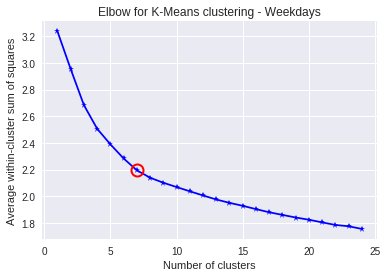

In [0]:
plot_elbow(weekdays, 25, mark=7, title='Elbow for K-Means clustering - Weekdays')

For weekdays will be choose 7 clusters

Weekends:

Calculating Kmeans...
Calculating distance...
All Done!


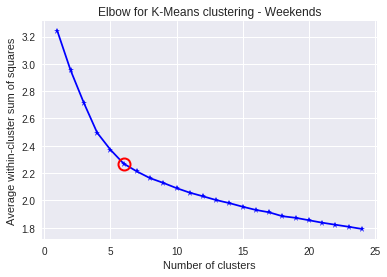

In [0]:
plot_elbow(weekends, 25, mark=6, title='Elbow for K-Means clustering - Weekends')

For weekends will be choose 6 clusters

## Plotting the clusterization

Weekdays:

In [12]:
x, y = kmeans2(weekdays, 7, iter = 20)

/usr/local/lib/python3.6/dist-packages/scipy/cluster/vq.py:525: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [0]:
label_color = [LABEL_COLOR_MAP[l] for l in y]

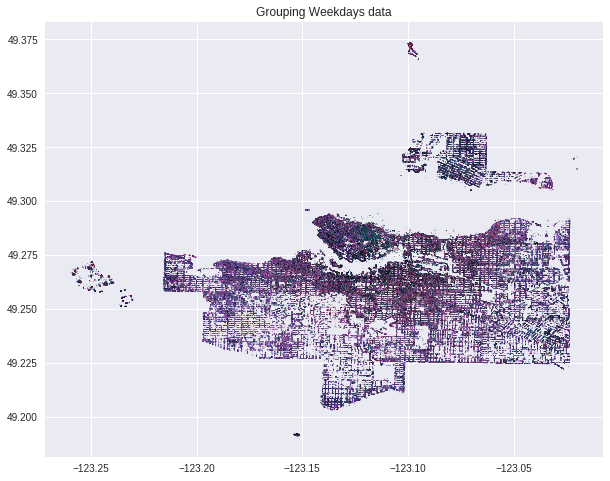

In [14]:
plt.figure(figsize=(10,8))
plt.scatter(weekdays['Start_lon'], weekdays['Start_lat'], c=label_color, s=0.1)
plt.title('Grouping Weekdays data')

plt.show()

In [0]:
# Column with groups
weekdays['cluster'] = y

Weekends:

In [0]:
x, y = kmeans2(weekends, 6, iter = 20, minit='points')

In [0]:
label_color = [LABEL_COLOR_MAP[l] for l in y]

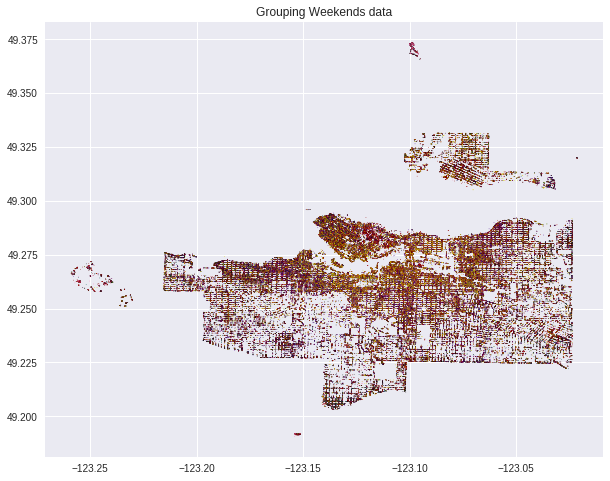

In [18]:
plt.figure(figsize=(10,8))
plt.scatter(weekends['Start_lon'], weekends['Start_lat'], c=label_color, s=0.1)
plt.title('Grouping Weekends data')

plt.show()

In [0]:
# Column with groups
weekends['cluster'] = y

## Creating a data structure of regions that have more concetration of a cluster:

In [0]:
# To-do: Use other points of Vancouver, with less distance between the points

In [0]:
# Points of vancouver region
points = pd.read_csv('malha.csv', names=['lon','lat'])

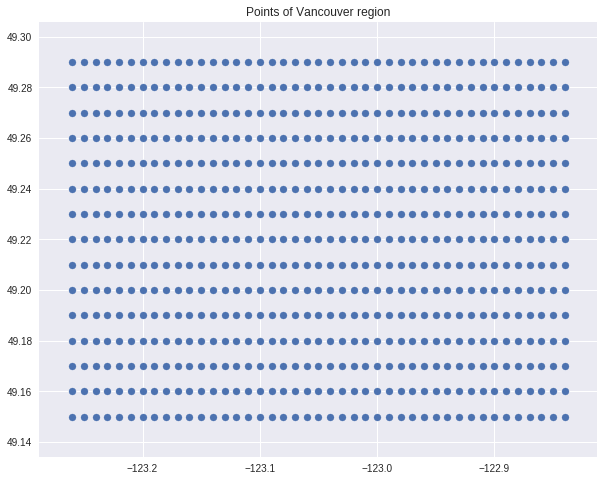

In [67]:
plt.figure(figsize=(10,8))
plt.scatter(points['lon'], points['lat'])
plt.title('Points of Vancouver region')

plt.show()

In [0]:
def geojson_builder(up_left,down_right,group):
    """
    Build a rectangle geojson from two points.
    """
    p1 = [str(up_left[0]),str(up_left[1])]
    p2 = [str(down_right[0]),str(up_left[1])]
    p3 = [str(down_right[0]),str(down_right[1])]
    p4 = [str(up_left[0]),str(down_right[1])]
    
    geojson = {"type": "FeatureCollection",
              "features": [
                {"type": "Feature",
                    "properties":{
                        "group": str(group)
                    },
                    "geometry": {
                        "type": "Polygon",
                        "coordinates": [[p1,p2,p3,p4,p1]] }}]}

    return geojson

In [0]:
def build_regions(data, points):
    """
    Create a list of geojsons that represent the group more 
    significant in the region.
    """
  
    # Creating matrix of the region coordinates
    # matrix dimensions based in points
    lat = points['lat'].unique()
    step = round(abs(lat[0]-lat[1]),5)
    diff = abs(lat.max() - lat.min())

    len_y = int(diff/step)+1

    lon = points['lon'].unique()
    step = round(abs(lon[0]-lon[1]),5)
    diff = abs(lon.max() - lon.min())

    len_x = int(diff/step)+1
    
    
    matrix = []

    # filling the matrix with the points coordinates
    c = 0
    for y in range(len_y):
        line = []
        for x in range(len_x):
            line.append((points['lon'].iloc[c], points['lat'].iloc[c]))
            c+=1
        matrix.append(line)

    geojsons = []
    
    for lin in range(len(matrix)-1):
        for col in range(len(matrix[0])-1):

            # Selecting all points inside a square of matrix coordinates
            up_left = matrix[lin][col]
            down_right = matrix[lin+1][col+1]
            
            lon_condition = (data['Start_lon'] >= up_left[0]) & (data['Start_lon'] <= down_right[0])
            lat_condition = (data['Start_lat'] <= up_left[1]) & (data['Start_lat'] >= down_right[0])

            travels = data[lon_condition & lat_condition]

            if len(travels) != 0:
                # Build a geojson of the group more significant in the square
                group = travels['cluster'].value_counts().index[0]
                geojsons.append(geojson_builder(up_left,down_right,group))
            
    return geojsons

In [0]:
def plot_regions(geo_jsons):
    """
    Plot a map of the regions.
    """
    
    plt.figure(figsize=(6,4))
    fig, ax = plt.subplots()
    
    for json in geo_jsons:
        coords = json['features'][0]['geometry']['coordinates'][0]
        group = int(json['features'][0]['properties']['group'])
        
        x = [i for i,j in coords]
        y = [j for i,j in coords]
        
        plt.plot(x,y, color=LABEL_COLOR_MAP[group])

    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    
    plt.show()

In [0]:
weekdays_geojsons = build_regions(weekdays, points)
weekends_geojsons = build_regions(weekends, points)

Weekdays regions:

<Figure size 432x288 with 0 Axes>

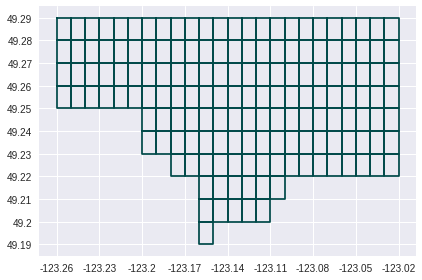

In [94]:
plot_regions(weekdays_geojsons)

Weekends regions:

<Figure size 432x288 with 0 Axes>

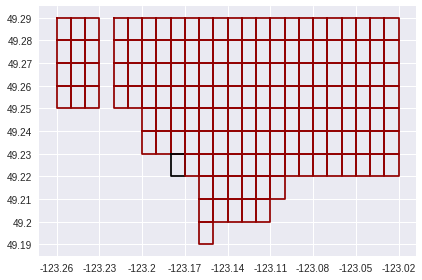

In [95]:
plot_regions(weekends_geojsons)

## Weekdays and Weekends data status

In [0]:
def count_busy(df, period):
    """
    Count business activity of each occurence of the dataframe in the 
    period.
    """

    busy = []
    idle = []

    # Vehicle id list in order to make a percentage of busy cars in each minute
    car_ids = df.Id.unique()
    n_cars = len(car_ids)

    # Going through each collected minute
    for dt in period:
        # Counting the number of travels that this minute is included
        in_travel = len(df[(df['Start_time'] <= dt) & (dt < df['End_time'])].Id.unique())
        percentage = (in_travel/n_cars) * 100

        busy.append([dt, in_travel, percentage])

    return pd.DataFrame(busy, columns=['capture_time','count','percentage'])

In [0]:
weekdays = evo_travels[evo_travels['weekday'] < 5]
weekends = evo_travels[evo_travels['weekday'] >= 5]

busy_weekdays = count_busy(weekdays,weekdays.Start_time.unique())
busy_weekends = count_busy(weekends,weekends.Start_time.unique())

busy_weekdays['hour'] = busy_weekdays.capture_time.dt.hour
busy_weekends['hour'] = busy_weekends.capture_time.dt.hour

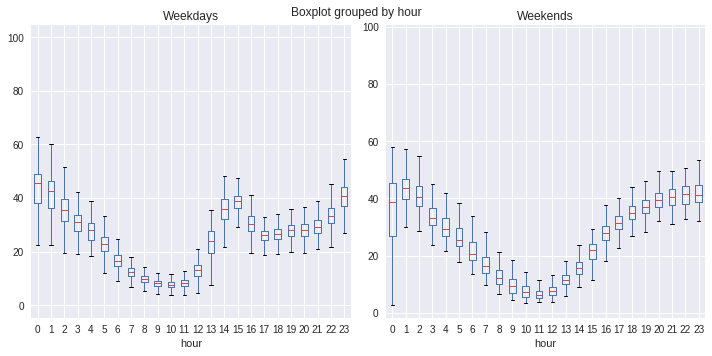

In [0]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(10,5)

busy_weekdays.boxplot(column='percentage',by='hour',ax=ax1)
ax1.set_title('Weekdays')

busy_weekends.boxplot(column='percentage',by='hour',ax=ax2)
ax2.set_title('Weekends')


fig.tight_layout()
plt.show()

### Fontes

* clusterização de viagens de bike in ny: https://chih-ling-hsu.github.io/2018/01/02/clustering-python
* clusterização basica de coordenadas: https://datascience.stackexchange.com/questions/761/clustering-geo-location-coordinates-lat-long-pairs
* aplicação do metodo elbow: https://nbviewer.jupyter.org/github/nborwankar/LearnDataScience/blob/master/notebooks/D3.%20K-Means%20Clustering%20Analysis.ipynb